In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

from zipfile import *

file_name = '/content/gdrive/My Drive/datasets/exp-data.zip'
with ZipFile(file_name, 'r') as f:
  f.extractall()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from keras.layers import Lambda

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# PATH = 'dataset/exp-data'
PATH = '/content/exp-data'
STORE_NAME = 'dcgan_dragan' # name of folders
store_image_dir = '{}_images'.format(STORE_NAME) # folder to store images for NN

# data variables
IMG_SIZE = 128
CHANNELS = 3
NOISE_DIM = 100

# create numpy array (tensor) for the dataset
train_images = np.ndarray(shape=(6000, IMG_SIZE, IMG_SIZE, CHANNELS), dtype=np.float32)

for i, img in enumerate(os.listdir(PATH)):
    if i >= 6000:
        break
    # using keras image preprocessing package convert the images into a matrix
    image = load_img(PATH + '/' + img)
    x = img_to_array(image)
    
    # add the matrices into the tensor
    train_images[i] = x

train_images = train_images/127.5 - 1 # normalize data to -1 to 1
train_images.shape

Using TensorFlow backend.


(6000, 128, 128, 3)

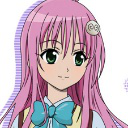

In [0]:
test = array_to_img(train_images[0])
test

## Hyperparameters

In [0]:
# training variables
EPOCHS = 300
BATCH_SIZE = 64

# hyperparameter tuning 
MOMENTUM = 0.8
WEIGHT_INIT_STDDEV =0.02
EPSILON = 0.00005
LEARNING_RATE=0.0002
BETA1 = 0.5
λ = 10

## Building the Generator

In [0]:
def phaseShift(inputs, scale, shape_1, shape_2):
    # Tackle the condition when the batch is None
    X = tf.reshape(inputs, shape_1)
    X = tf.transpose(X, [0, 1, 3, 2, 4])

    return tf.reshape(X, shape_2)

def pixelShuffler(inputs, scale=2):
    size = tf.shape(inputs)
    batch_size = size[0]
    h = size[1]
    w = size[2]
    c = inputs.get_shape().as_list()[-1]

    # Get the target channel size
    channel_target = c // (scale * scale)
    channel_factor = c // channel_target

    shape_1 = [batch_size, h, w, channel_factor // scale, channel_factor // scale]
    shape_2 = [batch_size, h * scale, w * scale, 1]

    # Reshape and transpose for periodic shuffling for each channel
    input_split = tf.split(inputs, channel_target, axis=3)
    output = tf.concat([phaseShift(x, scale, shape_1, shape_2) for x in input_split], axis=3)

    return output

In [0]:
def residual_block(inputs, train=True):
  X = tf.contrib.layers.convolution2d(inputs, 64, (3,3), (1,1), 
                                      padding='same', 
                                      weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                      activation_fn=None)
  X = tf.layers.batch_normalization(X)
  X = tf.nn.relu(X)
  X = tf.contrib.layers.convolution2d(inputs, 64, (3,3), (1,1), 
                                      padding='same', 
                                      weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                      activation_fn=None)
  X = tf.layers.batch_normalization(X)
  X = X + inputs # skip connection
  
  return X

In [0]:
def Generator(Z,reuse):
  with tf.variable_scope('generator',reuse=reuse):

    fully_connected = tf.contrib.layers.fully_connected(Z, 64*8*8, 
                                                        weights_initializer=tf.random_normal_initializer(stddev=WEIGHT_INIT_STDDEV),
                                                        activation_fn=None)
    fully_connected = tf.layers.batch_normalization(fully_connected)
    fully_connected = tf.reshape(fully_connected, (-1, 8, 8, 64))
    X = tf.nn.relu(fully_connected)

    X_shortcut = X

    for i in range(16):
      X = residual_block(X)

    X = tf.layers.batch_normalization(X)
    X = tf.nn.relu(X)
    
    X = X + X_shortcut

    X = tf.contrib.layers.convolution2d(X, 256, (3,3), (1,1), 
                                  padding='same', 
                                  weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                  activation_fn=None)
    X = pixelShuffler(X)
    X = tf.layers.batch_normalization(X)
    X = tf.nn.relu(X)

    X = tf.contrib.layers.convolution2d(X, 256, (3,3), (1,1), 
                                  padding='same', 
                                  weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                  activation_fn=None)
    X = pixelShuffler(X)
    X = tf.layers.batch_normalization(X)
    X = tf.nn.relu(X)

    X = tf.contrib.layers.convolution2d(X, 256, (3,3), (1,1), 
                                  padding='same', 
                                  weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                  activation_fn=None)
    X = pixelShuffler(X)
    X = tf.layers.batch_normalization(X)
    X = tf.nn.relu(X)

    X = tf.contrib.layers.convolution2d(X, 3, (9,9), (1,1), 
                                  padding='same', 
                                  weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                  activation_fn=None)
    X = tf.nn.tanh(X)

    return X

## Build the Discriminator

In [0]:
def disc_res_block(inputs, channels, f, s):
  X_shortcut = inputs
  X = tf.contrib.layers.convolution2d(inputs, channels, (f,f), (s,s), 
                                      padding='same', 
                                      weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                      activation_fn=None)
  X = tf.nn.leaky_relu(X)
  X = tf.contrib.layers.convolution2d(X, channels, (f,f), (s,s), 
                                      padding='same', 
                                      weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                      activation_fn=None)
  X = X + X_shortcut
  X = tf.nn.leaky_relu(X)
  
  return X

In [0]:
def Discriminator(X, reuse):
    with tf.variable_scope('discriminator', reuse=reuse): 
      
      X = tf.contrib.layers.convolution2d(X, 32, (4,4), (2,2), 
                                      padding='same', 
                                      weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                      activation_fn=None)
      X = tf.nn.leaky_relu(X)
      
      X = disc_res_block(X, 32, 3, 1)
      X = disc_res_block(X, 32, 3, 1)
      X = tf.contrib.layers.convolution2d(X, 64, (4,4), (2,2), 
                                      padding='same', 
                                      weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                      activation_fn=None)
      X = tf.nn.leaky_relu(X)
      
      X = disc_res_block(X, 64, 3, 1)
      X = disc_res_block(X, 64, 3, 1)
      X = disc_res_block(X, 64, 3, 1)
      X = disc_res_block(X, 64, 3, 1)
      X = tf.contrib.layers.convolution2d(X, 128, (4,4), (2,2), 
                                      padding='same', 
                                      weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                      activation_fn=None)
      X = tf.nn.leaky_relu(X)
      
      X = disc_res_block(X, 128, 3, 1)
      X = disc_res_block(X, 128, 3, 1)
      X = disc_res_block(X, 128, 3, 1)
      X = disc_res_block(X, 128, 3, 1)
      X = tf.contrib.layers.convolution2d(X, 256, (3,3), (2,2), 
                                      padding='same', 
                                      weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                      activation_fn=None)
      X = tf.nn.leaky_relu(X)
      
      X = disc_res_block(X, 256, 3, 1)
      X = disc_res_block(X, 256, 3, 1)
      X = disc_res_block(X, 256, 3, 1)
      X = disc_res_block(X, 256, 3, 1)
      X = tf.contrib.layers.convolution2d(X, 512, (3,3), (2,2), 
                                      padding='same', 
                                      weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                      activation_fn=None)
      X = tf.nn.leaky_relu(X)
      
      X = disc_res_block(X, 512, 3, 1)
      X = disc_res_block(X, 512, 3, 1)
      X = disc_res_block(X, 512, 3, 1)
      X = disc_res_block(X, 512, 3, 1)
      X = tf.contrib.layers.convolution2d(X, 1024, (3,3), (2,2), 
                                      padding='same', 
                                      weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                      activation_fn=None)
      X = tf.nn.leaky_relu(X)
      
      X = tf.reshape(X, (-1, 2*2*1024))
      logits = tf.layers.dense(X, 1)
      out = tf.nn.softmax(logits)
      return out, logits

## DRAGAN Loss Function

In [0]:
def get_perturbed_batch(minibatch):
  return minibatch + 0.5 * minibatch.std() * np.random.random(minibatch.shape)

In [0]:
x = tf.placeholder(tf.float32, shape=(None, 128, 128, 3))
x_p = tf.placeholder(tf.float32, shape=(None, 128, 128, 3))
z = tf.placeholder(tf.float32, shape=(None, NOISE_DIM))

g_sample = Generator(z, reuse=False)
d_model_real, d_logits_real = Discriminator(x, reuse=False)
d_model_fake, d_logits_fake = Discriminator(g_sample, reuse=True)

real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real))
fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
d_loss = tf.reduce_mean(real_loss+fake_loss)

# gradient penalty
alpha = tf.random_uniform(shape=[128,1], minval=0, maxval=1.)
differences = x_p - x
interpolates = x + (alpha * differences)
_, d_inter = Discriminator(interpolates, reuse=True)
gradients = tf.gradients(d_inter, [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
d_loss += λ * gradient_penalty

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='generator')
d_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='discriminator')

g_step = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1).minimize(g_loss,var_list = g_vars)
d_step = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1).minimize(d_loss,var_list = d_vars)

W0615 00:42:26.905561 139844235552640 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0615 00:42:27.198853 139844235552640 deprecation.py:323] From <ipython-input-7-830459469b91>:7: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
W0615 00:42:30.774601 139844235552640 deprecation.py:323] From <ipython-input-9-ef6237de8958>:59: dense (from tensorflow.python.layers.

## Training

In [0]:
try:
    os.makedirs(store_image_dir)
except FileExistsError:
    pass

try:
    os.makedirs('model')
except FileExistsError:
    pass

def show_samples(epoch, sample_images, dim=(4,4), figsize=(8,8)):
    plt.figure(figsize=figsize)
    for i, img in enumerate(sample_images):
        img = ((img+1.0)*127.5).astype('int')
        image = array_to_img(img)
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('{}/epoch {}.png'.format(store_image_dir, epoch))
    plt.show()
    plt.close()

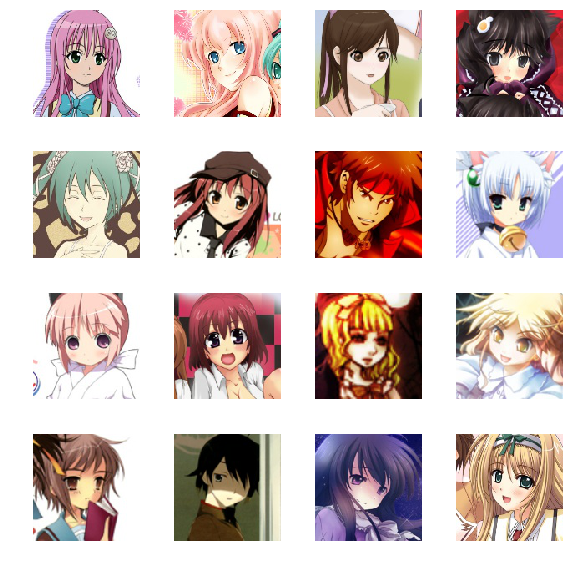

In [0]:
show_samples(0,train_images[:16])

In [0]:
dlosses = []
glosses = []

def train(epochs, batch_size=64,step=1):
    # training of (6000,128,128,3)
    m = train_images.shape[0] # number of training examples
    batch_count = m/batch_size # number of minibatches
    print ('Epochs:', epochs)
    print ('Batch size:', batch_size)
    print ('Batches per epoch:', batch_count)
    
    saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=2)
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      
      for e in range(step, epochs+1):
        for _ in tqdm(np.arange(batch_count)):
            # random m samples from gaussian distribution
            z_batch = np.random.uniform(-1, 1, size=(batch_size, NOISE_DIM))
            # getting m training samples
            x_batch = train_images[np.random.randint(0, train_images.shape[0], size=batch_size)]
            x_batch_p = get_perturbed_batch(x_batch)
            
            print(z_batch.shape)
            print(x_batch.shape)
            print(x_batch_p.shape)

            _,dloss,penalty = sess.run([d_step, d_loss, gradient_penalty],
                               feed_dict={x: x_batch, x_p: x_batch_p, z: z_batch})

            _,gloss = sess.run([g_step, g_loss],
                               feed_dict={z: z_batch})

        dlosses.append(dloss)
        glosses.append(gloss)

        print('Epoch: {}; D loss: {:.4}; G_loss: {:.4}; penalty: {:.4}'.format(e, dloss, gloss, penalty))

        if e == step or e % 5 == 0:
            z_batch = np.random.uniform(-1, 1, size=(batch_size, NOISE_DIM))
            generated_images = sess.run(g_sample, feed_dict={z: z_batch})
            show_samples(e, generated_images[:16])

        if e % 25 == 0 and e is not step:
            print('Model saved for epoch {}'.format(e))
            saver.save(sess,'model/{}-model'.format(STORE_NAME),global_step=e)

In [0]:
train(EPOCHS, batch_size=BATCH_SIZE)

Epochs: 300
Batch size: 16
Batches per epoch: 375.0


  0%|          | 0/375 [00:00<?, ?it/s]

(16, 100)
(16, 128, 128, 3)
(16, 128, 128, 3)


InvalidArgumentError: ignored

In [0]:
plt.plot(dlosses)
plt.plot(glosses)
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(['discriminator losses', 'generator losses'], loc='upper right')
plt.savefig('dcgan_dragan_losses.png')
plt.show()

In [0]:
!zip -r /content/file.zip /content/DCGAN_DRAGAN-images

In [0]:
!zip -r /content/file2.zip /content/model